In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib
%matplotlib inline

# Import Data

In [2]:
# Create training and testing dataframes
train_df = pd.read_csv('kc_house_data_train.csv')
holdout_df = pd.read_csv('kc_house_data_test_features.csv')

# Modeling

In [3]:
# Print column names
print(train_df.keys())

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [4]:
# Function to create age range dummy variables
def set_ages(df):
    age = df['yr_built']
    # df['age_new'] = np.where(age==2015, 1, 0)
    df['age_10'] = np.where((age>2004) & (age<2015), 1, 0)
    df['age_20'] = np.where((age>1994) & (age<2005), 1, 0)
    df['age_30'] = np.where((age>1984) & (age<1995), 1, 0)
    df['age_40'] = np.where((age>1974) & (age<1985), 1, 0)
    df['age_50'] = np.where((age>1964) & (age<1975), 1, 0)
    df['age_60'] = np.where((age>1954) & (age<1965), 1, 0)
    df['age_70'] = np.where((age>1944) & (age<1955), 1, 0)
    df['age_80'] = np.where((age>1934) & (age<1945), 1, 0)
    df['age_90'] = np.where((age>1924) & (age<1935), 1, 0)
    df['age_100'] = np.where((age>1914) & (age<1925), 1, 0)
    df['age_old'] = np.where((age<1915), 1, 0)
    return df

# Create age range dummy variables for dataframes
train_df = set_ages(train_df)
holdout_df = set_ages(holdout_df)

In [6]:
# Function to create renovation age range dummy variables
def set_ren_ages(df):
    age = df['yr_renovated']
    ren = age != 0
    df['ren_5'] = np.where(ren & (age>2010), 1, 0)
    df['ren_10'] = np.where((age>2005) & (age<2011), 1, 0)
    df['ren_15'] = np.where((age>2000) & (age<2006), 1, 0)
    df['ren_20'] = np.where((age>1995) & (age<2001), 1, 0)
    df['ren_25'] = np.where((age>1990) & (age<1996), 1, 0)
    df['ren_30'] = np.where((age>1985) & (age<1991), 1, 0)
    df['ren_old'] = np.where(ren & (age<1986), 1, 0)
    return df

# Create renovation age range dummy variables for dataframes
train_df = set_ren_ages(train_df)
holdout_df = set_ren_ages(holdout_df)

In [7]:
# Function for creating year dummy variables
def set_years(df):
    df['year'] = df['date'].apply(lambda x: int(x[0:4]))
    dummies = pd.get_dummies(df['year'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop('year', axis=1, inplace=True)
    return df

# Create year dummy variables for dataframes
train_df = set_years(train_df)
holdout_df = set_years(holdout_df)

In [8]:
# Function for creating month dummy variables
def set_months(df):
    months = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun',
              7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
    df['month'] = df['date'].apply(lambda x: int(x[4:6]))
    dummies = pd.get_dummies(df['month'], drop_first=True)
    for key in dummies.keys():
        if key in months.keys():
            dummies.rename({key : months[key]}, axis=1, inplace=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop('month', axis=1, inplace=True)
    return df

# Create month dummy variables for dataframes
train_df = set_months(train_df)
holdout_df = set_months(holdout_df)

In [9]:
# Function for creating zipcode dummy variables
def set_zipcodes(df):
    dummies = pd.get_dummies(df['zipcode'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    return df

# Create zipcode dummy variables for dataframes
train_df = set_zipcodes(train_df)
holdout_df = set_zipcodes(holdout_df)

In [10]:
# # Function for creating grade dummy variables
# def set_grades(df):
#     dummies = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
#     df = pd.concat([df, dummies], axis=1)
#     return df

# # Create grade dummy variables for dataframes
# train_df = set_grades(train_df)
# holdout_df = set_grades(holdout_df)

In [11]:
# Function to transform bedrooms outliers
def bedrooms_trans(df):
    filt = df['bedrooms'] < 10
    df['bedrooms'] = np.where(filt, df['bedrooms'], 10)
    return df

# Transform bedrooms outliers in dataframes 
train_df = bedrooms_trans(train_df)
holdout_df = bedrooms_trans(holdout_df)

In [12]:
# Function to transform bathrooms outliers
def bathrooms_trans(df):
    low_filt = df['bathrooms'] > .5
    df['bathrooms'] = np.where(low_filt, df['bathrooms'], .5)
    high_filt = df['bathrooms'] < 5
    df['bathrooms'] = np.where(high_filt, df['bathrooms'], 5)
    return df

# Transform bedrooms outliers in dataframes 
train_df = bathrooms_trans(train_df)
holdout_df = bathrooms_trans(holdout_df)

# Create Params

In [13]:
# Print column names
print(train_df.keys())

Index([ 'Unnamed: 0',          'id',        'date',       'price',
          'bedrooms',   'bathrooms', 'sqft_living',    'sqft_lot',
            'floors',  'waterfront',
       ...
               98146,         98148,         98155,         98166,
               98168,         98177,         98178,         98188,
               98198,         98199],
      dtype='object', length=121)


In [14]:
# Function to create features list
def set_features(df):
    ignore = ['Unnamed: 0', 'id', 'price', 'date', 'yr_built', 'yr_renovated',
              'zipcode', 'lat', 'long', 'sqft_living']
    features = list(df.keys())
    for feature in ignore:
        if feature in features:
            features.remove(feature)
    return features

# Create features list for dataframes
train_features = set_features(train_df)
holdout_features = set_features(holdout_df)

# EDA

In [15]:
# Print features list
print(train_features)

['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80', 'age_90', 'age_100', 'age_old', 'ren_5', 'ren_10', 'ren_15', 'ren_20', 'ren_25', 'ren_30', 'ren_old', 2015, 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155, 98166, 98168, 98177, 98178, 98188, 98198, 98199]


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


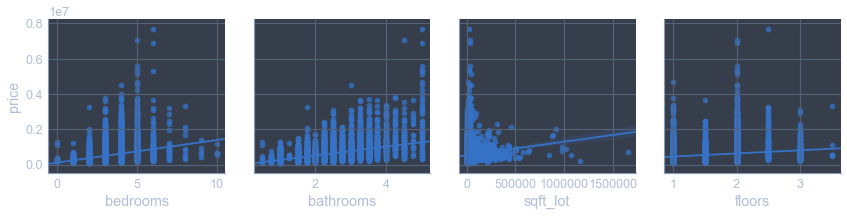

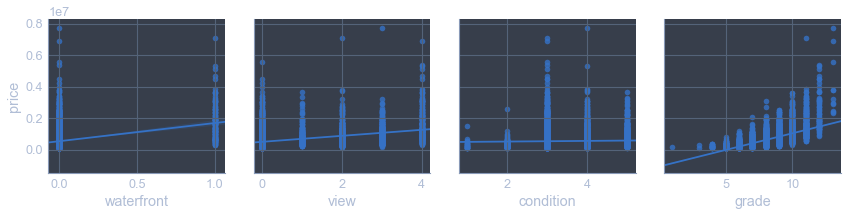

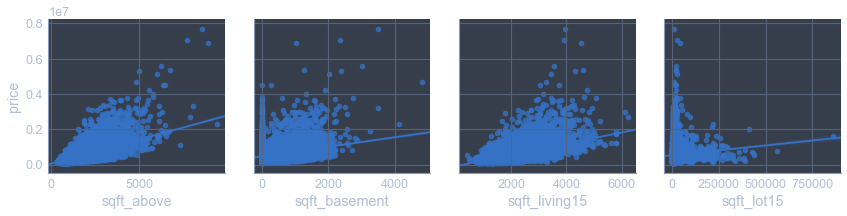

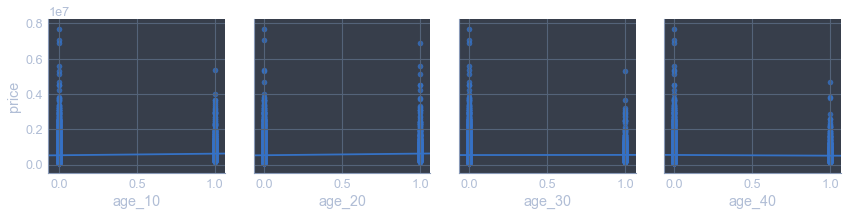

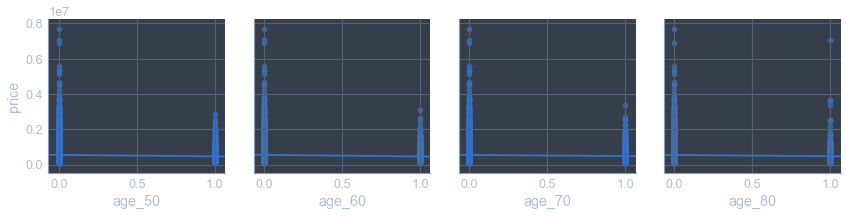

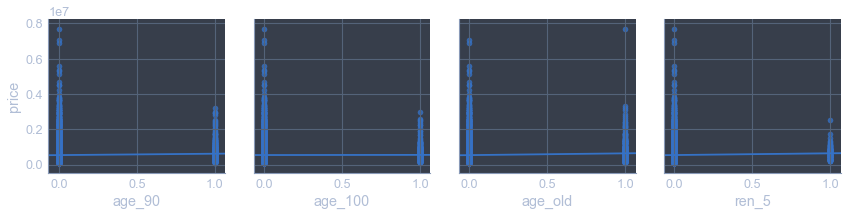

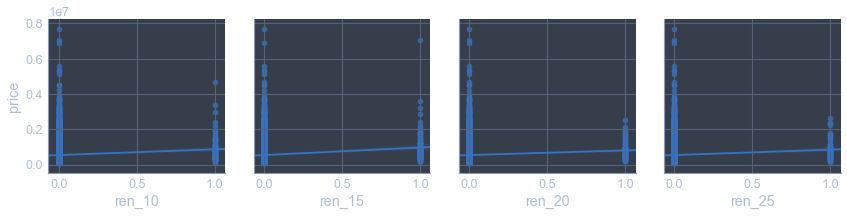

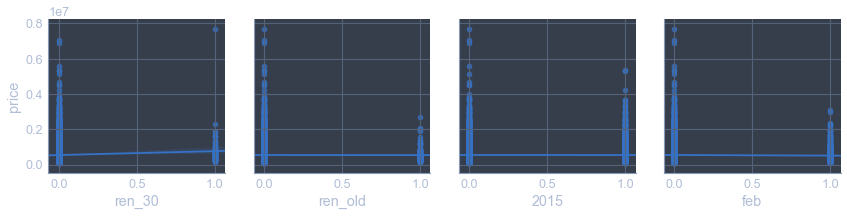

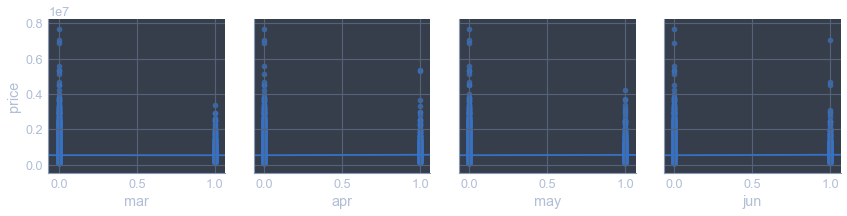

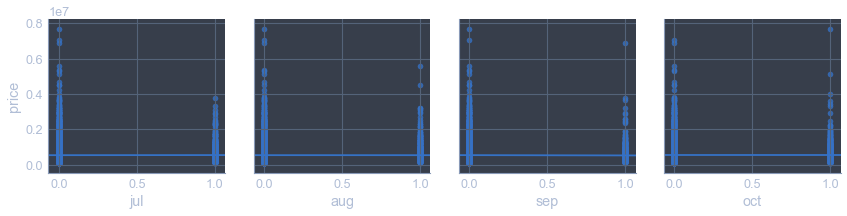

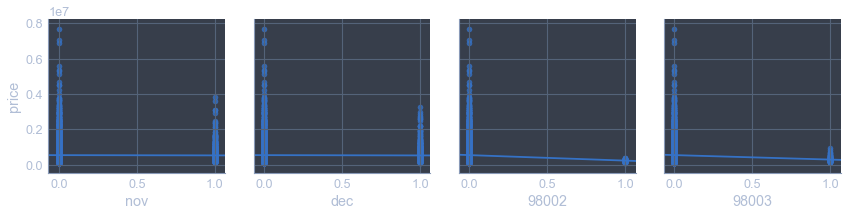

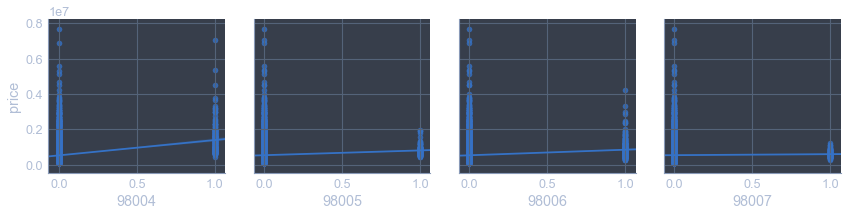

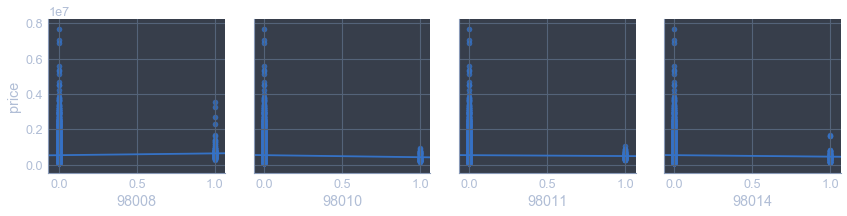

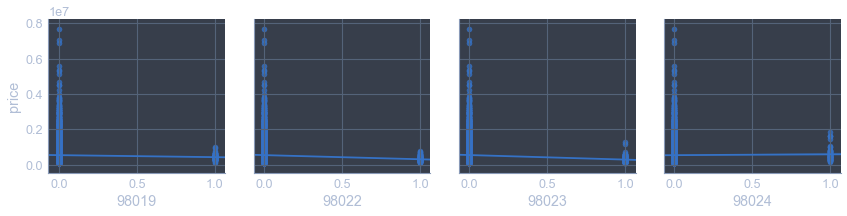

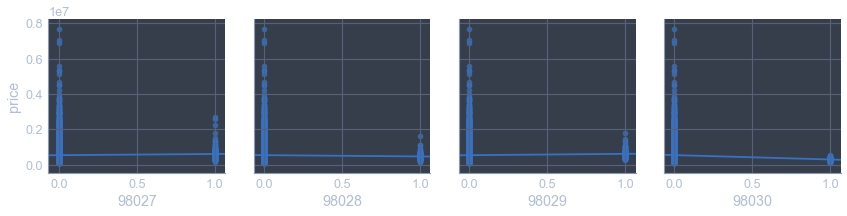

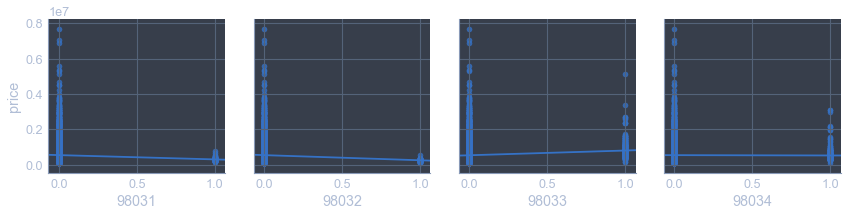

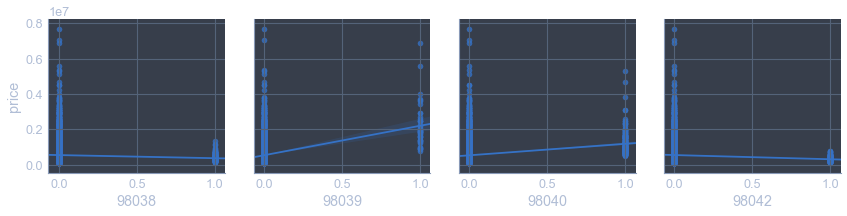

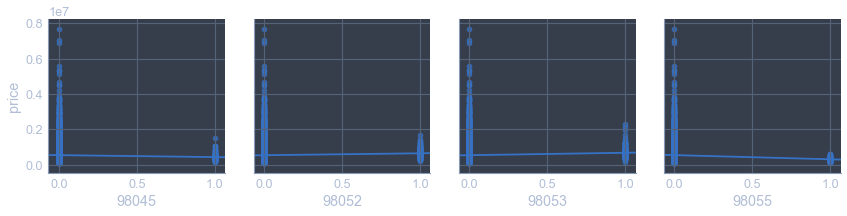

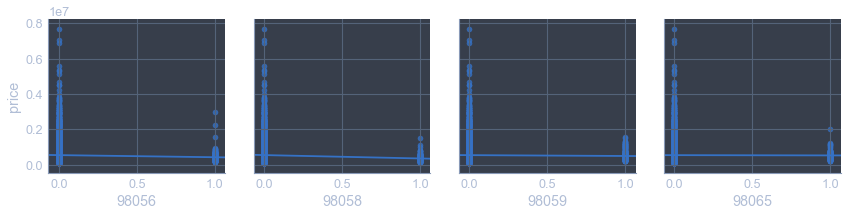

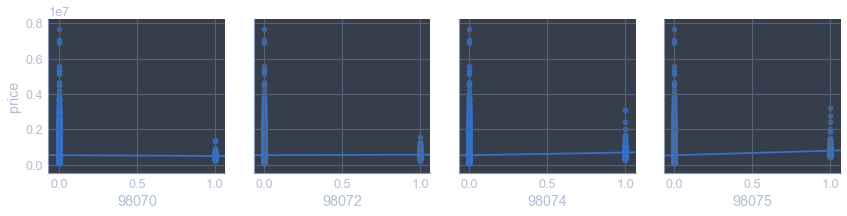

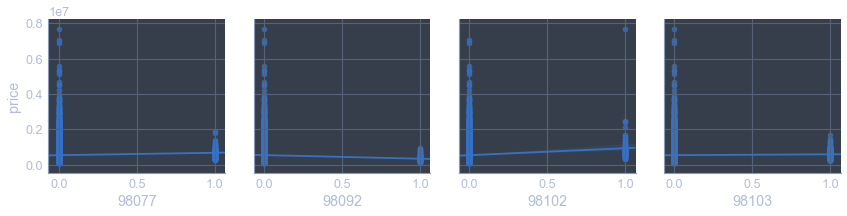

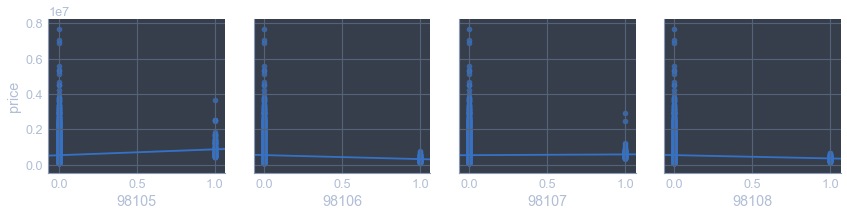

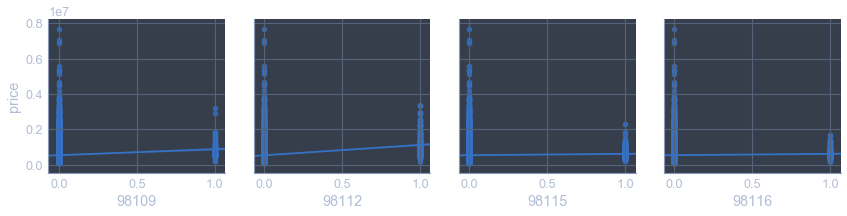

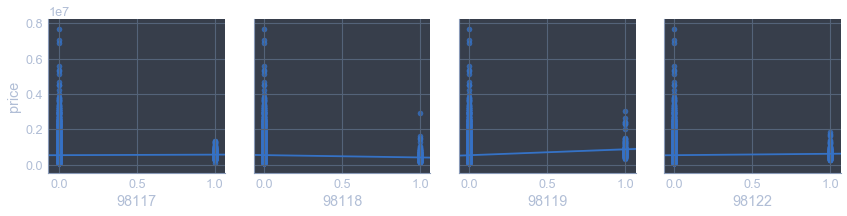

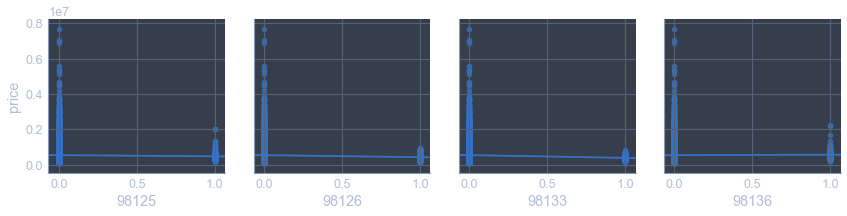

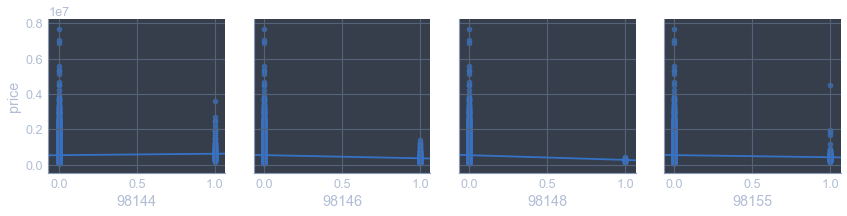

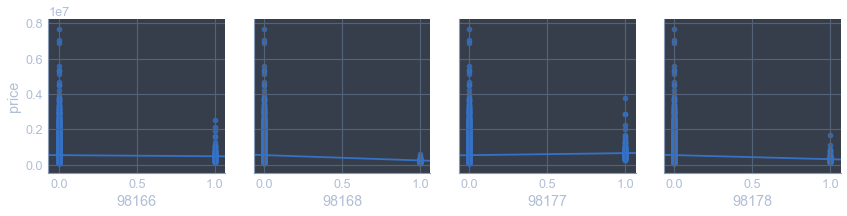

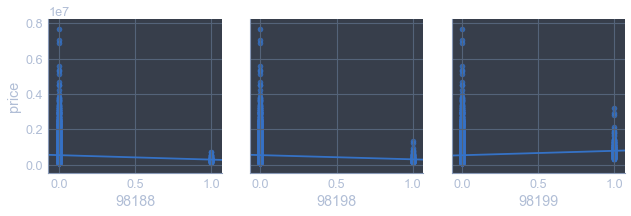

In [16]:
# Function to create feature pplots
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['price'], x_vars=row, kind='reg', height=3)
    return None

# Create feature pplots for training df
pplot_features(train_df, train_features)

# Run Model

In [17]:
# Print features list
print(train_features)

['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80', 'age_90', 'age_100', 'age_old', 'ren_5', 'ren_10', 'ren_15', 'ren_20', 'ren_25', 'ren_30', 'ren_old', 2015, 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155, 98166, 98168, 98177, 98178, 98188, 98198, 98199]


In [18]:
# Function to create regression model
def set_model(df, features):
    model = sm.OLS(df['price'], sm.add_constant(
        df[[key for key in train_features]])).fit()
    return model.summary()

# Run model on training dataframe
set_model(train_df, train_features)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     654.0
Date:                Sun, 03 May 2020   Prob (F-statistic):               0.00
Time:                        10:26:15   Log-Likelihood:            -2.3207e+05
No. Observations:               17290   AIC:                         4.644e+05
Df Residuals:                   17178   BIC:                         4.652e+05
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.612e+05   3.78e+04    -14.853      0.000   -6.35e+05   -4.87e+05
bedrooms       -2.72e+04   1839.508    -14.785      0.000   -3.08e+04   -2.36e+04
bathrooms      1.287e+04   3073.732      4.188      0.000    6846.876    1.89e+04
sqft_lot          0.2235      0.042      5.331      0.000       0.141       0.306
floors        -4.991e+04   3838.532    -13.003      0.000   -5.74e+04   -4.24e+04
waterfront     6.705e+05   1.57e+04     42.657      0.000     6.4e+05    7.01e+05
view            5.57e+04   1988.856     28.007      0.000    5.18e+04    5.96e+04
condition       2.98e+04   2227.618     13.375      0.000    2.54e+04    3.42e+04
grade          5.821e+04   2097.166     27.759      0.000    5.41e+04    6.23e+04
sqft_above      217.5778      3.454     62.989      0.000     210.807     224.348
sqft_basement   141.1094      4.033     34.988      0.000     133.204     149.015
sqft_living15     8.4664      3.310      2.558      0.011       1.979      14.954
sqft_lot15       -0.0638      0.068     -0.940      0.347      -0.197       0.069
age_10        -2.866e+04   3.08e+04     -0.931      0.352    -8.9e+04    3.17e+04
age_20        -3.752e+04   3.08e+04     -1.216      0.224    -9.8e+04    2.29e+04
age_30        -4.731e+04   3.09e+04     -1.530      0.126   -1.08e+05    1.33e+04
age_40        -4.321e+04   3.11e+04     -1.391      0.164   -1.04e+05    1.77e+04
age_50        -3.456e+04   3.12e+04     -1.107      0.268   -9.57e+04    2.66e+04
age_60        -3.358e+04   3.12e+04     -1.076      0.282   -9.48e+04    2.76e+04
age_70        -1.026e+04   3.13e+04     -0.328      0.743   -7.16e+04    5.11e+04
age_80          3.36e+04   3.15e+04      1.066      0.286   -2.82e+04    9.54e+04
age_90         2.415e+04   3.15e+04      0.767      0.443   -3.75e+04    8.58e+04
age_100        1.615e+04   3.16e+04      0.511      0.610   -4.58e+04    7.81e+04
age_old        2.697e+04   3.15e+04      0.857      0.392   -3.47e+04    8.87e+04
ren_5          6.591e+04   1.47e+04      4.476      0.000     3.7e+04    9.48e+04
ren_10         1.083e+05    1.7e+04      6.354      0.000    7.49e+04    1.42e+05
ren_15           1.1e+05    1.6e+04      6.889      0.000    7.87e+04    1.41e+05
ren_20        -5122.3980    1.8e+04     -0.284      0.776   -4.04e+04    3.02e+04
ren_25         4.637e+04   2.03e+04      2.281      0.023    6517.569    8.62e+04
ren_30         4178.2343   1.82e+04      0.229      0.819   -3.15e+04    3.99e+04
ren_old       -5.499e+04   1.37e+04     -4.023      0.000   -8.18e+04   -2.82e+04
2015           6.397e+04   8524.191      7.505      0.000    4.73e+04    8.07e+04
feb            1717.2113   7832.514      0.219      0.826   -1.36e+04    1.71e+04
mar            2.261e+04   7217.454      3.133      0.002    8464.222    3.68e+04
apr            3.118e+04   7004.992      4.451   

# Notes (TESTING)

In [19]:
# Recreate original dataframe without any added columns
TESTING = pd.read_csv('kc_house_data_train.csv')

# Create features list for original dataframe
TESTING_FEATURES = set_features(TESTING)

# Run model on original dataframe
set_model(TESTING, TESTING_FEATURES)

KeyError: "[98052, 98053, 98055, 'age_20', 98056, 98058, 98059, 'aug', 98065, 98070, 98072, 98074, 98075, 'age_10', 98077, 'oct', 'age_90', 'age_50', 'apr', 98092, 'age_40', 'feb', 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 'ren_25', 'age_100', 98122, 98125, 98126, 'may', 'ren_old', 98133, 98136, 'ren_20', 98144, 'jun', 98146, 98148, 98155, 98166, 98168, 98177, 98178, 'ren_30', 'mar', 'ren_5', 98188, 'age_old', 98198, 98199, 'sep', 'age_30', 'age_60', 'jul', 'nov', 'age_80', 'dec', 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 2015, 'ren_10', 'ren_15', 98019, 'age_70', 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045] not in index"

# Unused Functions

In [76]:
# # Function to create target variable
# def set_target(df):
#     target = df['price']
#     return target

# # Create target variable for dataframes
# train_target = set_target(train_df)
# test_target = set_target(test_df)

In [79]:
# # Filter extreme values
# def ext_values(df, extreme_cols):
#     new_df = df.copy()
#     for col in extreme_cols:
#         std = new_df[col].std()
#         mean = new_df[col].mean()
#         value = mean+(4*std)
#         new_df[col] = new_df[col].apply(lambda x: value if (x > 4*std) else x)
#     return new_df

In [40]:
# # Function to create regression modeln (smf method)
# def set_model(df, features):
#     formula = 'price~' + '+'.join([f'{ft}' for ft in features])
#     model = smf.ols(formula=formula, data=df).fit()
#     return model.summary()

# # Run model on train dataframe
# set_model(train_df, train_features)